In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from fBM import fBM_MC_pricer, fBM_sigkernel_pricer
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# model parameters
T, a         = 1., -.4
n_increments = 20
log_strike   = -5.  
payoff       = lambda p: max(np.exp(p[-1]) - np.exp(log_strike), 0.) # call
 
# evaluation points
n_eval       = 50
t_inds_eval  = np.random.choice(n_increments, n_eval)
paths_eval   = generate_X_theta_paths(t_inds_eval, n_increments, T, a)

# sigkernel parameters
sigma_t, sigma_sig, dyadic_order, max_batch = 0.5, 1e5, 1, 50

# error
error_fn, error_name, precisions = l2_error, 'L2_error', [1e-2, 1e-3, 1e-4]
# error_fn, error_name, precisions = linf_error, 'Linf_error', [1e-1]

In [4]:
# fig, ax = plt.subplots(1, 2, figsize=(11, 3))

# dW1 = np.random.multivariate_normal(np.array([0,0]), cov(a, n_increments), (n_eval, n_increments))[:,:,0]
# W1  = np.cumsum(dW1, axis=1)
# dt  = T/n_increments
# dW2 = np.random.randn(n_eval, n_increments)*np.sqrt(dt)
# W2  = np.cumsum(dW2, axis=1)

# for i in range(n_eval):
#     ax[0].plot(W1[i], alpha=0.1)
#     ax[1].plot(W2[i], alpha=0.1)
# plt.show()

In [5]:
# P = generate_X_theta_paths(np.array(n_eval*[n_increments-1]), n_increments, T, a)
# for i in range(n_eval):
#     plt.plot(P[i,:,1], alpha=0.3)
# plt.show()

In [6]:
# true prices
n_samples_MC_exact = 10000
mc_pricer_exact = fBM_MC_pricer(n_increments, n_samples_MC_exact, T, a)
mc_prices_exact = mc_pricer_exact.fit_predict(t_inds_eval, paths_eval, payoff)

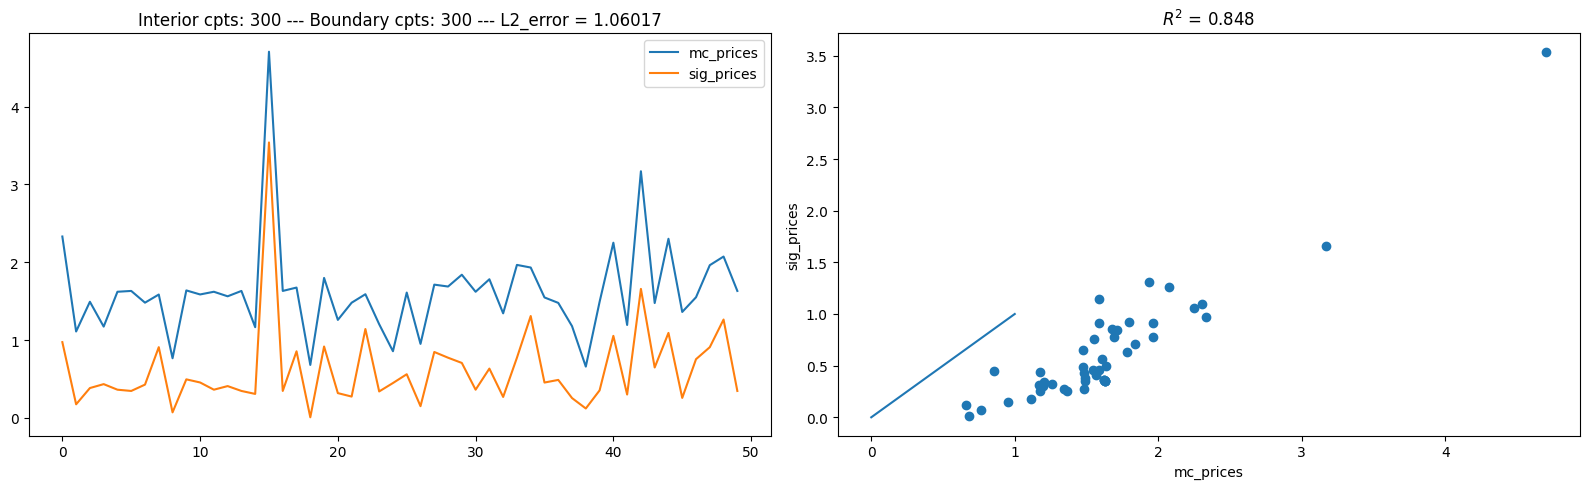

In [13]:
m = 300
n = 300

sigma_t, sigma_sig, dyadic_order, max_batch = 1e0, 1e6, 1, 100

sig_pricer = fBM_sigkernel_pricer(n_increments, m, n, T, a, sigma_t, sigma_sig, dyadic_order, max_batch, device)
sig_pricer.fit(payoff)
sig_prices = sig_pricer.predict(t_inds_eval, paths_eval) 
plot_results(mc_prices_exact, sig_prices, m, n, error_fn, error_name)

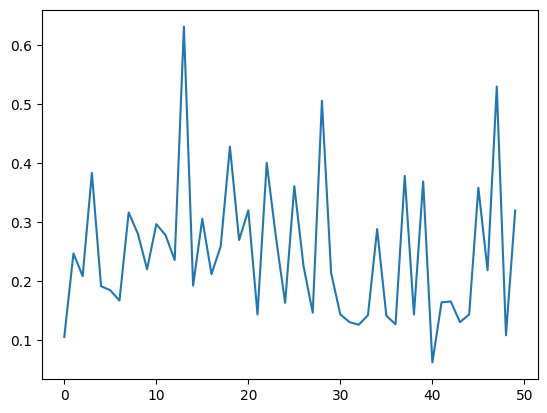

In [50]:
plt.plot(mc_prices_exact - sig_prices)

In [6]:
n_samples_mc, error_mc = 0, 1e9
m, n, error_sig        = 0, 0, 1e9

for precision in precisions:

    # MC prices
    while error_mc > precision:
        n_samples_mc += 5000
        mc_pricer = fBM_MC_pricer(n_increments, n_samples_mc, T, a)
        t0 = time.time()
        mc_prices = mc_pricer.fit_predict(t_inds_eval, paths_eval, payoff)
        t1 = time.time()
        error_mc  = error_fn(mc_prices, mc_prices_exact)

    print('Monte Carlo | %r: %2.5f | sample paths: %r | time: %2.4f sec' % (error_name, precision, n_samples_mc, t1-t0))
    
    # PPDE prices
    while error_sig > precision:
        m += 100
        n += 80
        sig_pricer = fBM_sigkernel_pricer(n_increments, m, n, T, a, sigma_t, sigma_sig, dyadic_order, max_batch, device)
        sig_pricer.fit(payoff)
        t0 = time.time()
        sig_prices = sig_pricer.predict(t_inds_eval, paths_eval) 
        t1 = time.time()
        error_sig = error_fn(sig_prices, mc_prices_exact)
        torch.cuda.empty_cache()

    print('PPDE (sigkernel) | %r: %2.5f | collocation points: (%r,%r) | time: %2.4f sec \n' % (error_name, precision, m, n, (t1-t0)/2))
